In [1]:
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import numpy as np
import torch

from environments.onestep import ARESEAOneStep
from oneshot0script import GaussianActor, Simulation

initializing ocelot...


## Bayesian Optimisation

In [2]:
env = ARESEAOneStep()
observation = env.reset()
before = env.segment.AREABSCR1.reading

In [3]:
def objective_fn(q1, q2, q3, cv, ch):
    action = np.array([q1, q2, q3, cv, ch])
    _, reward, _, _ = env.step(action)
    return reward

In [4]:
pbounds = {"q1": (-1,1), "q2": (-1,1), "q3": (-1,1), "cv": (-1,1), "ch": (-1,1)}

In [5]:
optimizer = BayesianOptimization(
    f=objective_fn,
    pbounds=pbounds
)
optimizer.maximize()

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        |  5.68     | -0.6103   | -0.6498   |  0.6012   | -0.7502   |  0.9036   |
|  2        |  3.882    | -0.4211   |  0.1186   | -0.6007   |  0.07574  | -0.4279   |
|  3        |  5.551    | -0.181    | -0.155    |  0.243    | -0.116    | -0.9574   |
|  4        |  5.142    | -0.3559   | -0.3067   |  0.6266   | -0.5265   |  0.5187   |
|  5        |  3.879    | -0.4573   | -0.1549   |  0.4186   |  0.5914   |  0.387    |
|  6        |  4.533    | -0.3712   | -0.767    |  0.8997   | -1.0      |  0.766    |
|  7        |  4.072    |  0.9597   | -0.8935   | -0.5392   |  0.9053   |  0.4437   |
|  8        |  3.409    |  0.2633   |  0.1296   |  0.9088   |  0.2525   |  0.8149   |
|  9        |  4.402    | -0.1684   |  0.3172   |  0.003991 |  0.1261   |  0.8881   |
|  10       |  3.022    |  0.548    |  0.6633   | -0.4

Desired: [-1.4836243e-03 -1.8799498e-03  1.3003152e-04  2.4626208e-05]
Objective: 6.488928522546991


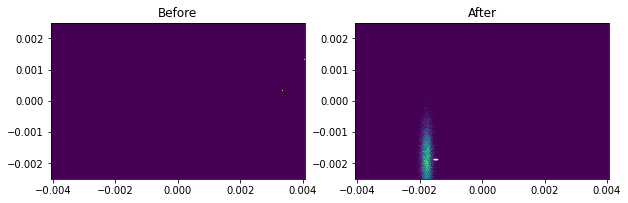

In [6]:
print("Desired:", env.desired)

screen = env.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

_, reward, _, _ = env.step(np.array([
    optimizer.max["params"]["q1"],
    optimizer.max["params"]["q2"],
    optimizer.max["params"]["q3"],
    optimizer.max["params"]["cv"],
    optimizer.max["params"]["ch"]
]))
print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

In [ ]:
plt.plot(optimizer.space.target)
plt.show()

In [7]:
simulation = Simulation()
simulation.reset(incoming=env.incoming, initial_actuators=env.initial_actuators, desired=env.desired)

array([ 2.7730844e+01,  1.6860699e+01, -2.9200151e+00,  1.5394255e-03,
        3.4728730e-03, -1.4836243e-03, -1.8799498e-03,  1.3003152e-04,
        2.4626208e-05,  7.0831371e-03,  3.8319458e-03,  9.2404307e-04,
        6.4695887e-03], dtype=float32)

In [8]:
def target_fn(q1, q2, q3, cv, ch):
    normalized_actuators = np.array([q1, q2, q3, cv, ch])
    actuators = normalized_actuators * simulation.actuator_space.high
    
    achieved = simulation.track(actuators)
    
    def objective_fn(achieved, desired):
        offset = achieved - desired
        weights = np.array([1, 1, 2, 2])

        return -np.log((weights * np.abs(offset)).sum())
    
    return objective_fn(achieved, simulation.desired)

In [9]:
pbounds = {"q1": (-1,1), "q2": (-1,1), "q3": (-1,1), "cv": (-1,1), "ch": (-1,1)}

In [10]:
optimizer = BayesianOptimization(
    f=target_fn,
    pbounds=pbounds
)
optimizer.maximize()

|   iter    |  target   |    ch     |    cv     |    q1     |    q2     |    q3     |
-------------------------------------------------------------------------------------
|  1        |  5.304    |  0.1808   | -0.5498   |  0.3743   | -0.9396   | -0.6784   |
|  2        |  3.673    |  0.5346   |  0.004676 | -0.3571   | -0.3216   | -0.5637   |
|  3        |  4.555    | -0.4362   |  0.4469   | -0.3495   |  0.8737   |  0.04955  |
|  4        |  3.555    | -0.0737   |  0.2985   |  0.7343   |  0.7682   |  0.1041   |
|  5        |  3.49     |  0.1867   | -0.04972  | -0.6829   | -0.2051   | -0.3956   |
|  6        |  4.404    | -0.5196   |  0.5343   | -0.2669   |  0.9097   |  0.06964  |
|  7        |  3.389    |  0.1122   | -0.8466   |  0.7786   | -1.0      | -0.8202   |
|  8        |  4.094    | -0.9363   |  0.8517   |  0.9894   | -0.3384   |  0.7029   |
|  9        |  4.61     |  0.2027   | -0.442    |  0.228    | -0.9268   | -0.6248   |
|  10       |  4.96     |  0.2275   | -0.5769   |  0.3

Desired: [-1.4836243e-03 -1.8799498e-03  1.3003152e-04  2.4626208e-05]
Objective: 5.7838440990671325


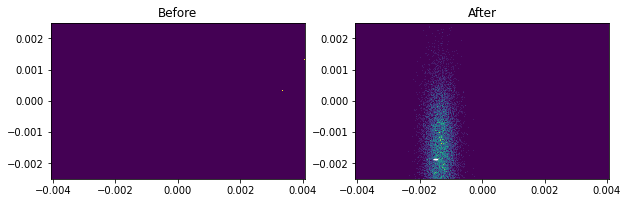

In [11]:
print("Desired:", env.desired)

screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

objective = target_fn(**optimizer.max["params"])

print("Objective:", objective)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

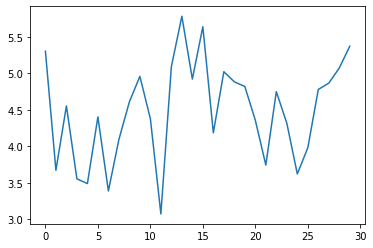

In [17]:
plt.plot(optimizer.space.target)
plt.show()

## Reinforcement Learning

In [12]:
timestamp = "20210908093749"
model = torch.load(f"models/onestep-model-{timestamp}.pkl")

Objective: 5.014599631175571


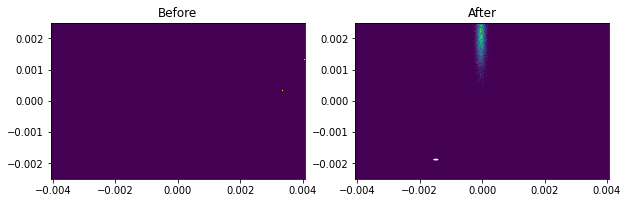

In [13]:
screen = env.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

torched_observation = torch.tensor(observation, dtype=torch.float32)
unsqueezed_observation = torched_observation.unsqueeze(0)
unsqueezed_actuators = model(unsqueezed_observation).sample()
torched_actuators = unsqueezed_actuators.squeeze()
actuators = torched_actuators.detach().numpy()
_, reward, _, _ = env.step(actuators)

print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = env.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()

In [14]:
simulation = Simulation()
simulation.reset(incoming=env.incoming, initial_actuators=env.initial_actuators, desired=env.desired)

array([ 2.7730844e+01,  1.6860699e+01, -2.9200151e+00,  1.5394255e-03,
        3.4728730e-03, -1.4836243e-03, -1.8799498e-03,  1.3003152e-04,
        2.4626208e-05,  7.0831371e-03,  3.8319458e-03,  9.2404307e-04,
        6.4695887e-03], dtype=float32)

Objective: 5.014599631175571


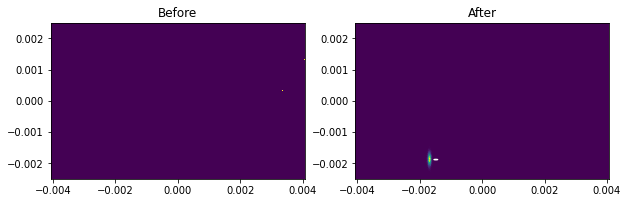

In [15]:
screen = simulation.segment.AREABSCR1

plt.figure(figsize=(10,5))

plt.subplot(121)
plt.imshow(before, extent=screen.extent, interpolation="None")
plt.title("Before")

observation_factor = np.concatenate([
    simulation.actuator_space.high,
    simulation.goal_space.high,
    simulation.goal_space.high
])

normalized_observation = observation / observation_factor
normalized_observation = torch.tensor(normalized_observation, dtype=torch.float32)
unsqueezed_observation = normalized_observation.unsqueeze(0)

unsqueezed_actuators = model(unsqueezed_observation).sample()

normalized_actuators = unsqueezed_actuators.squeeze()
actuators = normalized_actuators.detach().numpy() * simulation.actuator_space.high

simulation.track(actuators)

print("Objective:", reward)

plt.subplot(122)
plt.imshow(screen.reading, extent=screen.extent, interpolation="None")
mu_x, mu_y, sigma_x, sigma_y = simulation.desired
ellipse = Ellipse((mu_x,mu_y), sigma_x, sigma_y, fill=False, color="white")
plt.gca().add_patch(ellipse)
plt.title("After")

plt.show()